<h1>Klasifikasi Dokumen Berita BBC</h1>

Proyek ini bertujuan untuk mengklasifikasikan dokumen menggunakan Jaringan Saraf Tiruan (JST) (<i>Artificial Neural Network (ANN)</i>). Pada proyek ini kami juga akan menggunakan algoritma non JST yaitu : KNN sebagai metode pembanding. Score TF-IDF akan digunakan sebagai fitur dalam proyek ini, yang dimana selanjutnya dijadikan input untuk jaringan Saraf Tiruan. Dari proses training ini diharapkan mampu menghasilkan model yang handal dalam melakukan klasifikasi dokumen. Adapun alur proyek yang diadaptasikan dalam proyek ini adalah sebagai berikut :
<ol>
  <li>Load Dataset</li>
  <li>Preprocessing Data</li>
    <ul>
      <li>Lowercasing</li>
      <li>Tokenisasi</li>
      <li>Cleaning</li>
      <li>Stopword</li>
      <li>Steming</li>
      <li>Lematisasi</li>
      <li>Data Spliting</li>
    </ul>
  <li>Features Reduction(Optional)</li>
    <ul>
      <li>PCA</li>
      <li>Chi-Square</li>
    </ul>
  <li>Training Phase</li>
    <ul>
      <li>Backpropagation</li>
      <li>RNN</li>
      <li>KNN</li>
    </ul>
  <li>Testing Phase</li>
  <li>Result</li>
    <ul>
      <li>Confusion Matrix</li>
      <li>Accuracy</li>
      <li>Precision</li>
      <li>Recall</li>
      <li>F1 Score</li>
    </ul>
</ol>

<h2>Load Dataset</h2>

Dataset yang digunakan adalah <a href ="https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification">BBC Full Text Document Classification</a>. Dataset ini terdiri atas 2225 dokumen yang dikurasi dari website berita BBC dengan 5 kategori (bussines, entertainment, politics, sport dan tech). Dataset ini dikurasi dari tahun 2004 - 2005.

Sitasi : D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

In [4]:
# Data manipulation libraries.
import numpy as np
import pandas as pd
import spacy

# Data visualization libraries.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# General Imports
import os
import re
from tqdm import tqdm
from colorama import Fore, Style
from collections import Counter


# Library versions.
print("NumPy version:", np.__version__)
print("Spacy version:", spacy.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

NumPy version: 1.26.2
Spacy version: 3.7.4
Pandas version: 2.1.3
Matplotlib version: 3.8.2
Seaborn version: 0.13.0


<h3>Konstanta</h3>

In [35]:
DATA_DIR = "dataset/"
METADATA_CSV = "doc_metadata.csv"
PARSED_TEXT_CSV = "doc_parsed_text.csv"
FINAL_CSV = "doc_preprocessed.csv"

<h3>Daftar Fungsi</h3>

In [36]:
def display_as_table(headers, rows, align="r", add_sl_no=False):
    if isinstance(rows, pd.Series):
        rows = list(rows.iteritems())

    table = PrettyTable(align=align)

    if add_sl_no:
        table.field_names = ["No."] + list(headers)
        table.align["No."] = "r"
        rows = [[idx + 1] + list(row) for idx, row in enumerate(rows)]
    else:
        table.field_names = headers

    table.add_rows(rows)
    display(table)


to_dict = lambda frm_list: {item: frm_list.index(item) for item in frm_list}

def plot_elbow(ll, hl, col_name, df, y_label):
    plt.figure(figsize=(4, 3))

    pts = df[col_name].quantile(q=np.arange(ll, hl, 0.01))
    sns.lineplot(x=pts.index, y=pts)
    plt.title(f"{y_label} b/w {ll} & {round(hl - 0.01, 2)} percentile")
    plt.xlabel("Percentile")
    plt.ylabel(y_label)

    plt.show()
    
def is_empty(element):
    """
    Function to check if input element is empty.
    """

    if (isinstance(element, int) or isinstance(element, float)) and element == 0:
        # Exclude 0 and 0.0 from the Falsy set.
        return False
    elif isinstance(element, str) and len(element.strip()) == 0:
        # Include string with only one or more empty space(s) into Falsy set.
        return True
    elif isinstance(element, bool):
        # Exclude False from the Falsy set.
        return False
    else:
        return False if element else True

In [7]:
meta_data = []

folder_kategori = os.listdir(DATA_DIR)

for kategori in folder_kategori:
    path_kategori = os.path.join(DATA_DIR, kategori)
    if not os.path.isdir(path_kategori):
        continue

    nama_docs = os.listdir(path_kategori)
    for doc in nama_docs:
        path_doc = path_kategori + "/" + doc
        ukuran_doc = os.path.getsize(path_doc)
        nama_doc, ext = os.path.splitext(doc) 
        doc_id = kategori[0].upper() + "_" + nama_doc
        meta_data.append([kategori.capitalize(), doc_id, ukuran_doc, path_doc])

nama_kolom = ["Doc_Kategori", "Id_Doc", "Ukuran_Doc", "Path_Doc"]
meta_df = pd.DataFrame(data=meta_data, columns=nama_kolom)

meta_df.to_csv(METADATA_CSV, index=False, na_rep="")

meta_df["Doc_Kategori"] = meta_df["Doc_Kategori"].astype("category")

meta_df.sample(10)


,Doc_Kategori,Id_Doc,Ukuran_Doc,Path_Doc
1555,Business,B_211,1597,dataset/business/211.txt
1056,Entertainment,E_295,1318,dataset/entertainment/295.txt
1298,Business,B_341,1478,dataset/business/341.txt
1749,Sport,S_425,1797,dataset/sport/425.txt
791,Politics,P_173,2496,dataset/politics/173.txt
2166,Sport,S_010,1440,dataset/sport/010.txt
1533,Business,B_172,2516,dataset/business/172.txt
2185,Sport,S_021,1564,dataset/sport/021.txt
1967,Sport,S_316,1895,dataset/sport/316.txt
1351,Business,B_491,2127,dataset/business/491.txt


In [8]:
baris, kolom = meta_df.shape
print(f"Dataset terdiri dari {baris} baris and {kolom} kolom.\n")

meta_df.info()

Dataset terdiri dari 2225 baris and 4 kolom.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Doc_Kategori  2225 non-null   category
 1   Id_Doc        2225 non-null   object  
 2   Ukuran_Doc    2225 non-null   int64   
 3   Path_Doc      2225 non-null   object  
dtypes: category(1), int64(1), object(2)
memory usage: 54.7+ KB


Tidak ada data yang <i>missing</i>

<h3>Label Kategori</h3>

In [9]:
jum_kategori = meta_df["Doc_Kategori"].value_counts()

display_as_table(
  headers = ["Label Kategori", "Jumlah"],
  rows = list(zip(jum_kategori.index, jum_kategori.values)),
  add_sl_no = True
)

No.,Label Kategori,Jumlah
1,Sport,511
2,Business,510
3,Politics,417
4,Tech,401
5,Entertainment,386


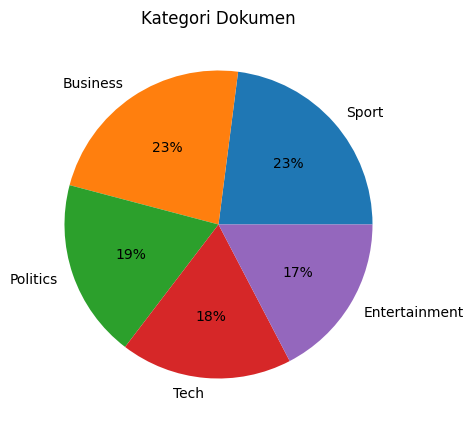

In [10]:
plt.figure(figsize=(5, 5))

plt.pie(x=jum_kategori, labels=jum_kategori.index, autopct="%1.0f%%")
plt.title("Kategori Dokumen")

plt.show()

In [11]:
codes, uniques = pd.factorize(meta_df["Doc_Kategori"])

cls_map = to_dict(uniques.categories.to_list())
print("Encoded class-labels:\n", cls_map)

meta_df["DocCat"] = codes
meta_df["DocCat"].value_counts().sort_index()

Encoded class-labels:
 {'Business': 0, 'Entertainment': 1, 'Politics': 2, 'Sport': 3, 'Tech': 4}


DocCat
0    401
1    417
2    386
3    510
4    511
Name: count, dtype: int64

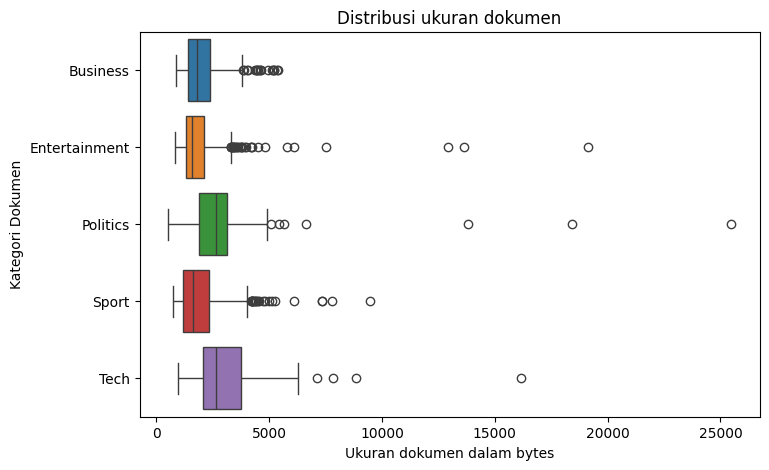

In [12]:
plt.figure(figsize=(8, 5))

sns.boxplot(data=meta_df, x="Ukuran_Doc", y="Doc_Kategori", palette="tab10", hue="Doc_Kategori", legend=False)
plt.title("Distribusi ukuran dokumen")
plt.xlabel("Ukuran dokumen dalam bytes")
plt.ylabel("Kategori Dokumen")

plt.show()

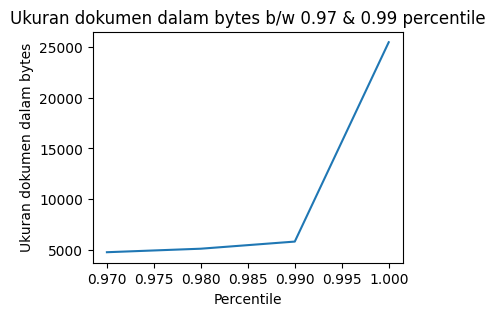

In [28]:
plot_elbow(0.97, 1, "Ukuran_Doc", meta_df, "Ukuran dokumen dalam bytes")

<b>Observations</b>

<ol>
    <li><b>99%</b> of documents have file size <b>less than ~6 KB.</b></li>
    <li><b>All documents</b> with file size <b>greater than 6 KB</b> can be considered as <b>outliers.</b></li>
</ol>

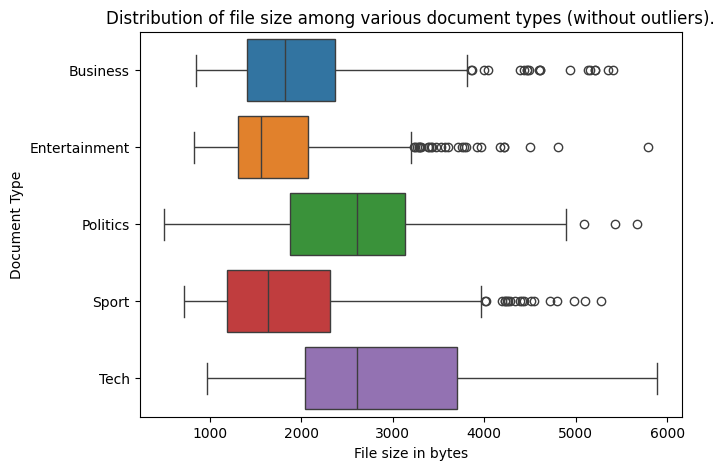

In [24]:
fltr = meta_df["Ukuran_Doc"] < 6_000

plt.figure(figsize=(7, 5))

sns.boxplot(data=meta_df[fltr], x="Ukuran_Doc", y="Doc_Kategori", palette="tab10", hue="Doc_Kategori", legend=False)
plt.title("Distribution of file size among various document types (without outliers).")
plt.xlabel("File size in bytes")
plt.ylabel("Document Type")

plt.show()

In [30]:
gte_6_KB = round(len(meta_df[~fltr]) / baris * 100, 1)
print(f"{gte_6_KB}% of documents are larger than 6 KB.")

0.9% of documents are larger than 6 KB.


<b>Observations</b>

<ol>
    <li>Distribution of FileSize features are overlapping for most of the document types.</li>
    <li>There is no visible pattern to differentiate various document types using only FileSize feature.</li>
    <li>Since only 0.9% of documents have file size greater than 6 KB, the outliers, they can be deleted later.</li>
    <li>Files of doc types tech and politics have larger file size compared to others.</li>
</ol>

In [31]:
fltr = meta_df["Ukuran_Doc"] > 6_000
outliers = meta_df.loc[fltr, "Doc_Kategori"].value_counts()
lost = np.round(np.divide(outliers.values, jum_kategori.values) * 100, 1)

display_as_table(
    headers=["Class label", "% of data lost per class"],
    rows=list(zip(jum_kategori.index, lost)),
    add_sl_no=True,
)

No.,Class label,% of data lost per class
1,Sport,1.2
2,Business,1.0
3,Politics,1.2
4,Tech,1.0
5,Entertainment,0.0


In [32]:
meta_df.drop(meta_df[fltr].index, inplace=True)

rows_wo, cols_wo = meta_df.shape  # wo :- Without outliers
print(f"Dataset contains {rows_wo} rows and {cols_wo} columns.")

Dataset contains 2205 rows and 5 columns.


In [33]:
SPECIAL_CHARS = r"([^a-z0-9\s])\1+"
flags_im = re.IGNORECASE | re.MULTILINE


def preprocess(text):
    # Replace consecutive similar special characters with space.
    text = re.sub(SPECIAL_CHARS, " ", text, flags=flags_im)

    # Compress text into a single line by replacing all
    # extra spaces, \t, \n, \r etc. with a single space.
    return re.sub(r"\s+", " ", text).strip()

In [34]:
inp_text = """
OMG!!!! This is line1.

Is this really line 2????


Some lengthy line -- to test text preprocessing. Oh! Text in "quotes" are not affected.
Are these preprocessing steps enough?
"""

print(preprocess(inp_text))

OMG This is line1. Is this really line 2 Some lengthy line to test text preprocessing. Oh! Text in "quotes" are not affected. Are these preprocessing steps enough?


In [38]:
if os.path.exists(PARSED_TEXT_CSV):
    print("Loading parsed text data of documents from:", PARSED_TEXT_CSV)
    prsd_df = pd.read_csv(PARSED_TEXT_CSV)
else:
    parsed_data = []
    for doc_id, file_path in tqdm(meta_df[["Id_Doc", "Path_Doc"]].values):

        # Read document as byte-file.
        with open(file_path, "rb") as txt_f:
            ip_text = txt_f.read().decode("utf-8", errors="ignore").strip()  # Input txt

            if is_empty(ip_text):
                continue

            op_text = preprocess(ip_text)
            parsed_data.append([doc_id, len(op_text), op_text])

    # Convert parsed text from documents into a DataFrame.
    col_names = ["DocId", "DocTextlen", "DocText"]
    prsd_df = pd.DataFrame(parsed_data, columns=col_names)

    # Save DataFrame as CSV file for future use.
    prsd_df.to_csv(PARSED_TEXT_CSV, index=False, na_rep="")
    print("Parsed text saved to:", METADATA_CSV)

prsd_df.head()

100%|██████████| 2205/2205 [29:49<00:00,  1.23it/s]

Parsed text saved to: doc_metadata.csv


,DocId,DocTextlen,DocText
0,T_395,4904,Cebit fever takes over Hanover Thousands of pr...
1,T_394,4887,TV's future down the phone line Internet TV ha...
2,T_392,2031,Broadband fuels online expression Fast web acc...
3,T_393,2862,Savvy searchers fail to spot ads Internet sear...
4,T_391,4946,Peer-to-peer nets 'here to stay' Peer-to-peer ...
